# Analysis of Urban-Traffic Simulated Data – part I
##### Ruggero Fabbiano – 24 November 2020

## Summary

With this notebook we start the exploration of a set of urban-traffic data obtained via the [SUMo simulator](https://www.eclipse.org/sumo/), an open-source microscopic traffic simulator that can take representations of real-world cities as input scenarios and can produce a variety of output data (vehicle state, road state, pollution information, etc.).

Here below we provide, for ease of comprehension, a brief summary of the scenario used and the output data generated, as well as the objectives of this first exploratory analysis.

#### Scenario
The scenario used for this simulation is the [**MoST** (_Monaco SUMo traffic_) scenario](https://github.com/lcodeca/MoSTScenario), which models the agglomeration area of the Principality of Monaco covering an area of about 70 km² (greater area). The simulated time can span at most from 4 AM to 2 PM, with a morning congestion towards the city modeled via a Gaussian vehicle demand of 20,000 objects, with average at 8:15 AM and standard deviation equal to 90'. <font color="blue">We have simulations spanning several time intervals, however the one used throughout this notebook covers time from 4 AM to 6 AM.</font> *Also, we made the choice to set a time step equal to 1 s, and saving the output each 5 s.*

#### Output
Among the possibilities SUMo offers for data generation, we chose the FCD (_floating car data_) output, which is focused on the vehicle information. To help you better understand the analysis that follow, here below a resume of the data that the floating-car output generates:

* `timestep_time` [s] – the current simulation time (0 corresponds to the beginning of the day)
* `vehicle_id` / `person_id` – a unique object identifier
* `vehicle_angle` / `person_angle` [°] – orientation of the object in navigational standard (0-360°)
* `vehicle_lane` – the ID of the lane the vehicle is currently moving onto
* `vehicle_pos` / `person_pos` [m] – running position of the object from the start of the current lane
* `vehicle_slope` / `person_slope` [°] – slope of the object lane at object position
* `vehicle_speed` / `person_speed` [m/s] – absolute speed of the object
* `vehicle_type` – the type of the vehicle (private vehicle, Uber, delivery truck etc.)
* `vehicle_x` / `person_x` [m] – absolute _x_ coordinate / longitude of the object
* `vehicle_y` / `person_y` [m] – absolute _y_ coordinate / latitude of the object
* `vehicle_z` / `person_z` [m] – elevation of the object
* `person_edge` – edge the virtual footpath where the person is moving on is connected to

##### Goal
The first part of the analysis focuses on checking if we can reduce the sparsity of the dataset, thus having to handle a lighter and more compact dataframe. <font color="fuchsia">Then, we start investigating the data by checking their properties described in the MoST article.</font> <font color="blue">A deeper analysis will be the object of a following notebook.</font>

 ***

## Import Packages and Data

Let's be sure we have all the necessary packages installed:

In [3]:
!pip install pandas
!pip install datetime
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install wget

We can now import them:

In [1]:
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('bmh')

Now to the data.

Let's define the local path to the CSV file, as well as the remote one; we will then be able to load the local file if present, or download it otherwise.

In [2]:
out_file = 'most_0400_0600_1_5.csv'
local_fp = './' + out_file
remote_fp = 'https://standard-traffic-data.s3.us-east-2.amazonaws.com/' + out_file

In [3]:
!wget -nc $remote_fp -O $local_fp

File './most_0400_0600_1_5.csv' already there; not retrieving.


In [4]:
data = pd.read_csv(out_file, sep=';', low_memory=False)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2067350 entries, 0 to 2067349
Data columns (total 20 columns):
timestep_time    float64
vehicle_angle    float64
vehicle_id       object
vehicle_lane     object
vehicle_pos      float64
vehicle_slope    float64
vehicle_speed    float64
vehicle_type     object
vehicle_x        float64
vehicle_y        float64
vehicle_z        float64
person_angle     float64
person_edge      object
person_id        object
person_pos       float64
person_slope     float64
person_speed     float64
person_x         float64
person_y         float64
person_z         float64
dtypes: float64(15), object(5)
memory usage: 315.5+ MB


We now have our dataset ready.
In the next section we're going to see if we can reduce its memory usage without information loss.

## Data cleaning

### Drop empty rows

<font color ="green">

It's generally useful to wipe rows of the dataset that contain just null values (whichever representation of null is there).

In this case though, no row will ever be entirely null, because the `timestep_time` feature is always given.

I could potentially filter out all rows that have all features null, excluding `timestep_time`. However, I think it's worth keeping them: they can show to us at what timestep we start seeing traffic.
    
</font>

<font color ="gray">
    
Son d'accordo in generale sull'operazione preliminare sui NAN; non l'ho ritenuto necessario in questo caso visto che i dati provengono da una simulazione e non sono grezzi. Riguardo all'arrivo del primo oggetto avendo essi una distribuzione normale ho ipotizzato che statisticamente le linee che potremmo "risparmiare" sarebbero poche (ed effettivamente sia nel 4-6 che nel 4-8 il primo oggetto arriva al 2° istante).

In ogni caso ho aggiunto il _sanity check_ memorizzando prima gli "istanti d'interesse" (vedi sotto).

</font>

Let's start by doing a sanity check over the timestep feature (that should always be not null):

In [54]:
assert data.shape == data.dropna(how='all').shape

We can now check some relevant time steps, like the first one, the last one and the time the first object appears, so that we can later drop all the rows with no active object:

In [5]:
def t_format(timestep):
    return str(datetime.timedelta(seconds=timestep))

In [6]:
t_s = data['timestep_time'].iloc[0] # first data timestep
t_e = data['timestep_time'].iloc[-1] # last data timestep

i_first = data[['vehicle_id', 'person_id']].first_valid_index()
t_o = data['timestep_time'].iloc[i_first] # timestep of first object start

We're now ready to drop the empty rows:

In [7]:
data.drop(data.index[:i_first], inplace=True)
data.reset_index(drop=True, inplace=True)

### Feature cleaning

<font color ="green">

This idea deserves a verbal explanation, and it's not entirely clear to me.

Here's my (tentative) understanding:
- You consider features in pairs of columns, by looking for similar feature names.

Let's consider the first predicata only: `bothNAN`:
  - For each pair of columns, you keep elements of the first column only in the positions where the second column is null
  - At this point you have a Sequence (list-like). You call isna() on this sequence, which will yield a list of boolean values.
  - Each of these values will be True if the corresponding first column's element is null and the second column's element is also null.
  - Then you check if **any** of the values in such list of booleans is True.
  - Eventually, you will know if there was at least one position in those two columns where both were null. **At least one**.
  
Later on, if the result value for a pair of column was False, meaning that there wasn't any row in the dataset where those two columns are both null, you fill the null of the first column with the values from the second (which won't be null).

I can't see the idea behind this. Why would the missing values in `vehicle_angle` be in `person_angle`?

</font>

<font color ="gray">

Riguardo alla parte non chiara, l'assunzione (banale) non è che i valori mancanti in una colonna son nell’altra, ma più che altro i valori non sono "mancanti" ma divisi fra due colonne diverse, una `vehicle_` e l'altra `person_`.

L’obiettivo era verificare quest'ipotesi e capire si possono quindi accorpare due colonne, diverse ma che contengono la stessa informazione, risparmiando così un sacco di valori nulli e la metà delle colonne, con conseguente gran risparmio di memoria nel caricare il _dataframe_ (circa il 50 %, piuttosto importante viste le dimensioni del _data set_ – e la memoria del mio computer :)). A proposito di ciò, era questo il pre-trattamento che dicevo si poteva fare a monte prima del caricamento del CSV.

Lascia stare la vecchia implementazione, che era _logicamente_ non ottimale (riformulata qui sotto), ma l'idea di fondo qui è assicurarsi che non ci siano valori in entrambe le colonne per ogni coppia, di modo da poter fonderle senza paura di perdere delle informazioni.

</font>

<font color ="green">

Site notes:

1. Calling isna -> values -> any should be redundant. I think you can just use any() on the data frame.
Example:

```
d1 = pd.DataFrame.from_dict({'a': [1, 2, np.nan, 3, 4], 'b': [9, np.nan, 13, 6, 11]})
print(d1.head())
both_nan = d1['a'][d1['b'].isna()].isna().any()
print('column "a": ', both_nan)
```

</font>

<font color ="gray">

Sì sì `values` è chiaramente inutile, un refuso di quando l'avevo chiamato su tutto il _dataframe_ usato per evitare di ottenere una serie:
```
data[(data['vehicle_lane'].notna()) & (data['person_edge'].notna())].any()
```

</font>

<font color ="green">

3. Assuming my understading is correct, here's a much simpler way to do it. And much more readable
```
np.where((d1['a'].isna()) & (d1['b'].isna()), True, False).any()
```

</font>
    
<font color ="gray">OK</font>

<font color ="green">

2. Save the features that you will want to drop/fill in a variable, depending on the true/false result. And then execute your next block of code based on this additional variable. Right now you execute it just looking at the visual output of the previous cell, but this requires editing it manually.

</font>

<font color ="gray">

Buona idea effettivamente. Credo sia abitudine dai _notebook_ che ho visto durante i miei corsi, più orientati a mostrare visualmente una cosa e spiegare che cosa fanno basato esclusivamente su quello che abbiamo visto prima...

</font>

We can now focus on the features. If we look back at the feature names it looks like some of them are repeated twice, both for persons and vehicles. We can probably merge them to reduce the size of the dataset.

Before doing that, we need to be sure that the information is divided into the couple of features, so that we won't lose any data.

The suspects seem to be `angle`, `id`, `pos`, `slope`, `speed`, `x`, `y`, and `z`. Let's check them:

In [9]:
features = ['angle', 'id', 'pos', 'slope', 'speed', 'x', 'y', 'z']
mergeable_features = [f for f in features if
                      np.where((data['vehicle_'+f].notna()) & (data['person_'+f].notna()), False, True).any()]

mergeable_features

['angle', 'id', 'pos', 'slope', 'speed', 'x', 'y', 'z']

The vector obtained above tells us which features have information split between the two columns of the couple; in such case we can safely merge them without losing any information. 

In [10]:
for f in mergeable_features:
    data['vehicle_'+f].fillna(data['person_'+f], inplace=True)
    data.drop('person_'+f, axis='columns', inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2067349 entries, 0 to 2067348
Data columns (total 12 columns):
timestep_time    float64
vehicle_angle    float64
vehicle_id       object
vehicle_lane     object
vehicle_pos      float64
vehicle_slope    float64
vehicle_speed    float64
vehicle_type     object
vehicle_x        float64
vehicle_y        float64
vehicle_z        float64
person_edge      object
dtypes: float64(8), object(4)
memory usage: 189.3+ MB


Also `vehicle_lane` and `person_edge` seem to carry the same information (where in the network the object currently is); let's repeat the process for this couple of features:

In [11]:
if np.where((data['vehicle_lane'].notna()) & (data['person_edge'].notna()), False, True).any():
    data['vehicle_lane'].fillna(data['person_edge'], inplace=True)
    data.drop('person_edge', axis='columns', inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2067349 entries, 0 to 2067348
Data columns (total 11 columns):
timestep_time    float64
vehicle_angle    float64
vehicle_id       object
vehicle_lane     object
vehicle_pos      float64
vehicle_slope    float64
vehicle_speed    float64
vehicle_type     object
vehicle_x        float64
vehicle_y        float64
vehicle_z        float64
dtypes: float64(8), object(3)
memory usage: 173.5+ MB


We can now rename the features to make them more understandeable (the `vehicle` prefix does not make any sense anymore), and take a look at our more compact dataframe:

In [12]:
data.rename(columns={'timestep_time': "t", 'vehicle_angle': "angle", 'vehicle_id': "ID", 'vehicle_pos': "position",
                     'vehicle_slope': "slope", 'vehicle_speed': "speed", 'vehicle_x': "x", 'vehicle_y': "y",
                     'vehicle_z': "z", 'vehicle_lane': "lane_edge", 'vehicle_type': "v_type", }, inplace=True)
data.head()

,t,angle,ID,lane_edge,position,slope,speed,v_type,x,y,z
0,14405.0,80.89,bus_M1:France.0,152927_1,12.10,3.01,0.00,bus,1085.69,197.96,54.34
1,14410.0,71.94,bus_M1:France.0,152927_1,23.63,1.31,3.97,bus,1096.59,201.56,54.75
2,14415.0,57.57,bus_M1:France.0,152927_1,57.99,0.66,8.49,bus,1126.83,217.57,55.32
3,14420.0,32.10,bus_M1:France.0,152927_1,113.32,0.63,12.78,bus,1167.22,253.89,55.41
4,14425.0,53.85,bus_M1:Eze.0,-153460_1,18.12,1.73,3.09,bus,44.23,1368.97,358.63


## Exploratory Data Analysis

Let's verify the starting and ending time of the simulation, and when the first vehicle (or person) appears:

<font color ="green">

You are assuming the CSV is sorted :)
To be safe, better to use `pd.min` and `pd.max`

</font>

<font color ="gray">

Capisco l'idea (e ovviamente nessun problema a usare min./max.), ma in questo caso è un po' come un postulato che è lecito presupporre no? I dati vengono da una simulazione, non son grezzi, e conosciamo il formato dell'output perché lo produciamo noi.

</font>

In [13]:
print("Data time interval:", t_format(t_s), "–", t_format(t_e))
print("First object appears at", t_format(t_o))

Data time interval: 4:00:00 – 5:59:55
First object appears at 4:00:05


Let's see now how many objects are active for each time step; given the traffic distribution (normal with _μ_ at 8:15 AM and _σ_ equal to 90'), we would expect them to be substantially increasing since around 5 AM.

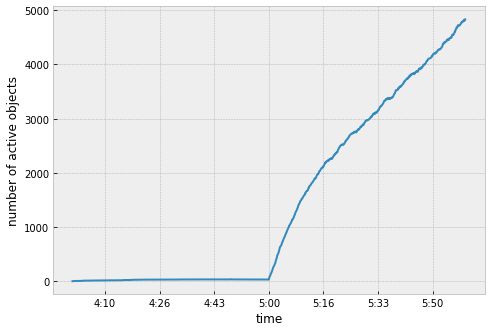

In [145]:
ax = plt.figure().add_axes([0, 0, 1, 1])

ax.plot(data.groupby(['t']).count()['ID'])

# ax.set_title('Active objects')
ax.set_xlabel('time')
ax.set_ylabel('number of active objects')

labels = []
for tick in ax.get_xticks():
    labels.append(t_format(tick)[:-3])
ax.set_xticklabels(labels);

<font color="green">
Side Note: I think the code below is more standard for plotting data frames.
</font>

<font color="gray">

Ho qualche osservazione su questo punto:
* Osservazione sullo _standard code_ un po' come per la storia del _linting_, :) ma lasciamola per due chiacchiere a voce
* La mia idea era non di fare il grafico cumulato, ma vedere quali erano i periodi più pieni di veicoli diciamo
* Perché assegni il plot?
* Il tuo codice non mi funziona (vedi sotto), e anche nella _signature_ della funzione non vedo effettivamente `xlabel` e `ylabel`!

</font>

AttributeError: 'Line2D' object has no property 'xlabel'

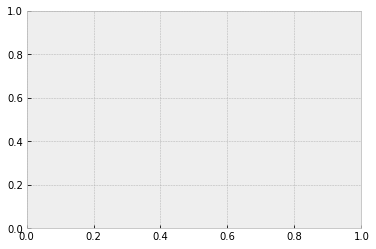

In [147]:
grouped = data.groupby(['t']).count()['ID']
cumulated = grouped.cumsum()
x_ticks = range(int(cumulated.index.min()), int(cumulated.index.max()), 1000)
_ = cumulated.plot(x=cumulated.index, y='ID',
                   kind='line', xticks=x_ticks,
                   xlabel='t [sec from midnight]', ylabel='num objects')

Let's focus now on the life time of the objects in the simulation; given the size of the area, we expect a time spanning from a few minutes to probably less than an hour.

In [14]:
ID_per_t = data.groupby('ID').count()['t']
Delta = np.diff(data['t'].unique())[0]

print(F"Min. life time: {int((ID_per_t.min()-1)*Delta/60)} m {int((ID_per_t.min()-1)*Delta % 60)} s")
print(F"Max. life time: {int((ID_per_t.max()-1)*Delta/60)} m {int((ID_per_t.max()-1)*Delta % 60)} s")

Min. life time: 0 m 0 s
Max. life time: 59 m 50 s


Weirdly, it looks like some objects only appear in the simulation for one time step:

In [15]:
ID_per_t[ID_per_t==ID_per_t.min()]

ID
pedestrian_1-1-pt_3865       1
pedestrian_1-1-pt_3865_tr    1
pedestrian_1-1-pt_4564       1
pedestrian_1-1-pt_4564_tr    1
pedestrian_1-1-pt_7931       1
pedestrian_1-1-pt_7931_tr    1
pedestrian_1-1-pt_821        1
pedestrian_1-1-pt_821_tr     1
pedestrian_1-1-veh_522       1
pedestrian_1-1-veh_522_tr    1
pedestrian_1-2_3             1
pedestrian_1-2_3_tr          1
pedestrian_1-3_1755          1
pedestrian_1-3_1755_tr       1
pedestrian_1-GW1_2157        1
pedestrian_1-GW1_2157_tr     1
pedestrian_1-GW2_963         1
pedestrian_1-GW2_963_tr      1
pedestrian_GW1-1_2022        1
pedestrian_GW1-1_2022_tr     1
Name: t, dtype: int64

<font color="green">We need to make an assumption, or give an explanation for this seemingly nonsense. Is it a "bug" in their simulation?</font>

<font color="gray">Un _bug_, o magari si allontanano da un nodo periferico? In qualche caso partenza e destinazione possono coincidere (tra l'altro son al 99 % pedoni, e se no veicoli speciali)? O son pedoni generati in un nodo che non ha corsie accessibili ai pedoni? In ogni caso credo che per rispondere servirebbe analizzarne il percorso col `--tripinfo-output` e/o altre opzioni (magari il log della simulazione?).</font>

Let's count the total number of vehicles and pedestrians in the dataset; given the spanning time and the demand distributions, we should have not more than 10 % of the 20 thousands vehicles overall.

In [159]:
p = len(data['ID'][data['v_type'].isna()].unique())
v = len(data['ID'][data['v_type'].notna()].unique())

print(F"{p+v} objects in the simulations, divided into {p} pedestrians and {v} vehicles of any type")

# sanity check
assert p+v == len(data['ID'].unique())

11991 objects in the simulations, divided into 5843 pedestrians and 6148 vehicle of any type


<font color="gray">This seems to me contradicting the assumption of a 20-thousand objects demand with normal distribution around 8:15 AM. It is worth noticing that `pedestrian` and `pedestrian_tr` is in some sense the same object, but still it makes too much (and in the 4-8 simulation it was even more than 20 k vehicles).</font>

Let's take a look now at the object demand by time:

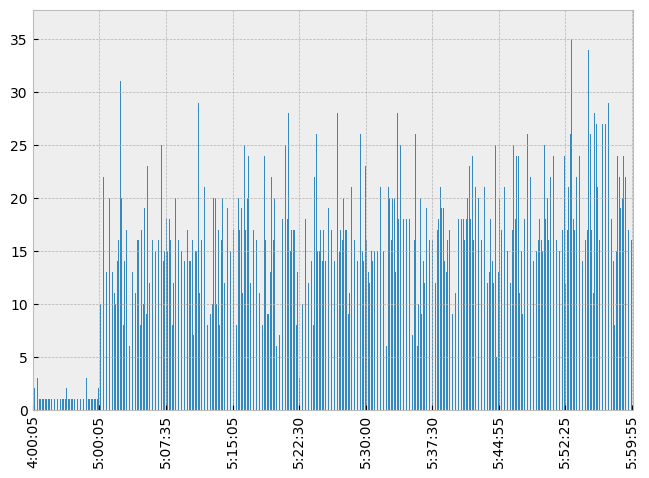

In [81]:
new_obj_per_time = data.groupby('ID').min()['t'].value_counts().sort_index()

fig = plt.figure(dpi=100)
ax = fig.add_axes([0, 0, 1, 1])
new_obj_per_time.plot.bar()

tick_pos = np.linspace(0, len(new_obj_per_time)-1, 10, dtype=int)
ax.set_xticks(tick_pos);
ax.set_xticklabels([t_format(t) for t in new_obj_per_time.index[tick_pos]]);


<font color="green">

Riguardo ai tuoi commenti alla vecchia versione qui sotto:

</font>

<font color="gray">

"conosco"  `apply`, ma evidentemente non abbastanza da capire come avrei potuto usarlo qua. Però ho pensato che con la soluzione qui sopra non è necessario; che ne pensi?

</font>

<font color="gray">

In ogni caso anche questo risultato mi sembra poco coerente con la distribuzione gaussiana... forse difficile da vedere nel tempo scelto? O sbaglio qualcosa io?

</font>

In [ ]:
timeSteps = data['t'].unique()
newObjByTime = pd.Series(0, index=timeSteps)

# I believe this is a good excuse to learn pd.apply and then remove this loop. It's very slow!!
# I waited more than 2 minutes then I stopped it (that's why you see the error)
# I added dropna otherwise you get an error at runtime.
for obj in data['ID'].dropna().unique():
    timeFirstAppeared = data[data['ID']==obj]['t'].values[0]
    newObjByTime[timeFirstAppeared]+=1